In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, './TetrisEnv')
from TetrisBattle.envs.tetris_env import TetrisSingleEnv, TetrisEnv
from TetrisBattle import *
# %pip install -e ./TetrisEnv
# import TetrisBattle

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload
%autoreload 2

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


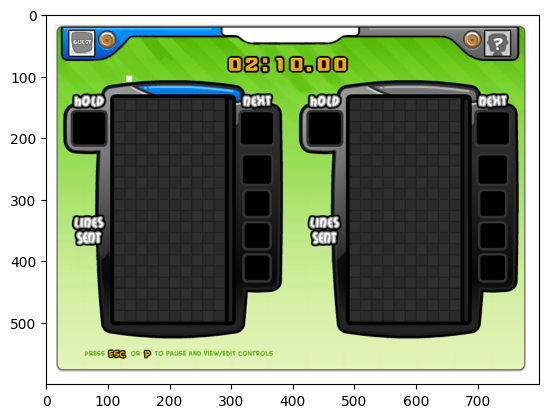

In [9]:
from gym.wrappers import GrayScaleObservation
from preprocessing.EensyWeensy import MakeEensyWeensy
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# from gym import make
# env = make('SinglePTetris-v0')
env = TetrisSingleEnv()
ob = env.reset()
dots = np.ones((20, 10))
x = 100
y = 130
ob[x:x+10,y:y+10] = [255,255,255]
plt.imshow(ob, cmap="plasma")

In [4]:
env = GrayScaleObservation(env, keep_dim=True)
env = MakeEensyWeensy(env, cut_in_half=True, scale=.25)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order="last")

In [5]:
ob,_,_,_ = env.step([0])
ob.shape

(1, 150, 100, 4)

In [6]:
# for i in range(0, 1000):
#     action = env.random_action()
#     state, reward, done, info = env.step(action)
#     env.render()
#     i += 1
# env.close()

In [7]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
import torch
print(torch.cuda.is_available())
check_env(TetrisSingleEnv())

True


In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [9]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [10]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [11]:
try:
    del model
except NameError:
    pass
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-2, n_steps=512, device="cuda") 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [12]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/PPO_27
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 79.7     |
|    ep_rew_mean     | -37.8    |
| time/              |          |
|    fps             | 74       |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 512      |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 143       |
|    ep_rew_mean          | -36.2     |
| time/                   |           |
|    fps                  | 70        |
|    iterations           | 2         |
|    time_elapsed         | 14        |
|    total_timesteps      | 1024      |
| train/                  |           |
|    approx_kl            | 9.327778  |
|    clip_fraction        | 0.951     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.182    |
|    explained_variance   | -0.000216 |
|    learning_rate        | 0.01   

KeyboardInterrupt: 

In [13]:
model = PPO.load('./train/best_model_20000')
#env = TetrisSingleEnv()
state = env.reset()
i = 0

while True:
    if (i >= 1000):
        env.close()
        break
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
    i += 1

: 